## Nonlinear pulse propagation

From Marc's paper.

In [1]:
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2
# %matplotlib notebook

import numpy as np
from numpy.fft import *
import matplotlib.pyplot as plt
import time
import scipy
from matplotlib import cm

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.analysis import FTX, IFTX
os.chdir(cwd)

In [2]:
#Change size of plots
plt.rcParams['figure.figsize'] = [14, 5]

## Units
We'll work in the following units:

time = fs <br>
frequency = PHz (1/time) <br>
distance = mm

In [3]:
from scipy.constants import pi, c
c = c*1e-12; #mm/fs, [Freq]=PHz

## Single Pass

In [4]:
def nonlinear_operator(a,b,kappa):
    f = ifft(kappa*fft(b*np.conj(a)))
    g = -ifft(kappa*fft(a*a))
    return np.array([f,g])

In [5]:
def single_pass(a,b,Da,Db,kappa,L,h):
    
    for kz in range(int(L/h)):
        #Linear step
        a = ifft(Da*fft(a))
        b = ifft(Da*fft(b))
        
        #Nonlinear step
        #Runge-Kutta
        [k1, l1] = h*nonlinear_operator(a,b,kappa)
        [k2, l2] = h*nonlinear_operator(a+k1/2,b+l1/2,kappa)
        [k3, l3] = h*nonlinear_operator(a+k2/2,b+l2/2,kappa)
        [k4, l4] = h*nonlinear_operator(a+k3,b+l3,kappa)
                                               
        a = a + (1/6)*(k1+2*k2+2*k3+k4)
        b = b + (1/6)*(l1+2*l2+2*l3+l4)

    return a,b

## OPO

In [6]:
def opo(b_input, N, L, h, Da, Db, fb, kappa):
    '''
    Inputs:
    b: pump pulse
    N: number of rountrips
    L: length of the crystal
    h: spatial step on the crystal
    Da: Dispersion operator of crystal at signal
    Db: Dispersion operator of crystal at pump
    fb: Feedback operator
    kappa: nonlinear coupling
    
    Outputs:
    a: signal pulse after N roundtrips
    b: pump pulse after last roundtrip
    '''
    
    #Initialize signal as random
    NFFT = b.size
    #noise = 1e-10*np.random.normal(size=NFFT)
    noise = 1e-10*np.ones(NFFT)
    a = noise
    
    evol = np.zeros([N, NFFT])
    for kn in range(N):
        a,b_output = single_pass(a,b_input,Da,Db,kappa,L,h)
            
        #Apply feedback
        a = ifft(fb*fft(a))
        
        evol[kn,:] = (np.abs(a)/np.max(np.abs(a)))**2; #Round-trip evolution
        
        if (kn+1)%50==0:
            print('Completed roundtrip ' + str(kn+1))
    
    return a, b_output, evol

## Time and Frequency domain windows

In [7]:
#Simulation window setup
NFFT = 2**12 #Fourier size

Tmax = 1000 #(fs) window will go from -Tmax to Tmax)
t = np.linspace(-Tmax, Tmax, NFFT)
ts = t[1]-t[0] #Sampling period
print('Sampling Rate =', ts, 'fs')
# window = np.hamming(N)

#Frequency domain
Omega = 2*pi*fftfreq(t.size, ts) #Angular frequencies
print('Freq max =', np.amax(Omega)*1e3/(2*pi), 'THz')
print('Freq resolution =', Omega[1]*1e3/(2*pi), 'THz')

Sampling Rate = 0.4884004884005435 fs
Freq max = 1023.2501220701971 THz
Freq resolution = 0.4998779296874436 THz


## Input parameters

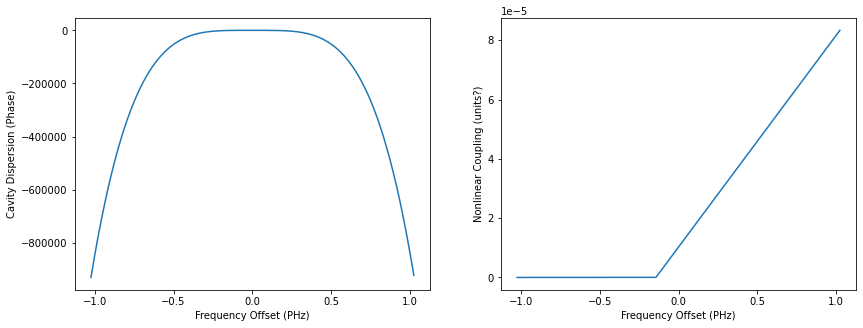

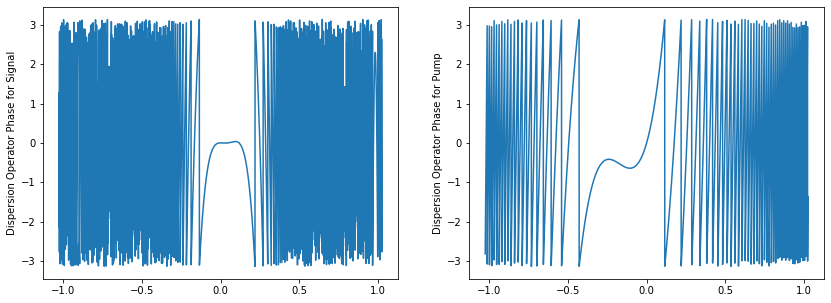

In [8]:
#Input parameters

#OPO parameters
wla = 2.090e-3 #signal wavelength (mm)
wlb = wla/2 #pump wavelength (mm)
wa = 2*pi*c/wla #
Co_loss = 1-0.65  #Output coupler loss
dT = 4 #Detuning in fs
l = c*dT/wlb #Detuning parameter l
pump_pwr = 0.5 #Average pump power (W)
Tp = 70 #Input pulse width (fs)
Ws = 14e-3 #Beam waist of signal (mm)
Nrt = 200 #Round trips

#Cavity dispersion parameters
phi2 = 25*2
phi3 = 76
phi4 = -13020
# phi5 = 983328
phi5 = 0

#Crystal parameters
L = 1 #mm
h = L/50 #Distance step Size

alpha_a = 0.00691 #loss for signal in crystal (1/mm)
alpha_b = 0.00691 #loss for pump in crystal (1/mm)

u = 112.778 #Group velocity mismatch (fs/mm)
b2a = -53.64 #second order GVD signal (fs^2/mm)
b3a = 756.14 #third order GVD signal (fs^3/mm)
b4a = -2924.19 #fourth order GVD signal (fs^4/mm)
b2b = 240.92 #second order GVD pump (fs^2/mm)
b3b = 211.285 #second order GVD pump (fs^3/mm)
b4b = -18.3758 #second order GVD pump (fs^4/mm)
deff = 2/pi*16e-12 #effective nonlinear coefficient (mm/V)
na = 2.2333# refractive index at signal
nb = 2.1935# refractive index at pump

kappa = np.sqrt(2*377)*deff*(Omega+wa)/(Ws*na*c*np.sqrt(pi*nb)) #Nonlinear coupling
kappa = np.clip(kappa, a_min=0, a_max=None)
# kappa = 0.01*np.ones_like(Omega)

#Linear operators
Da = alpha_a/2 - 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6 - 1j*b4a*Omega**4/24
Db = alpha_b/2 - 1j*u*Omega - 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6 - 1j*b4b*Omega**4/24
Da = np.exp(-h*Da)
Db = np.exp(-h*Db)

#Feedback loop
deltaphi = (phi2/2)*Omega**2 + (phi3/6)*Omega**3 + (phi4/24)*Omega**4 + (phi5/120)*Omega**5
phi = pi*l + dT*Omega + deltaphi
fb = np.sqrt(Co_loss)*np.exp(-1j*phi)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(fftshift(Omega)/(2*pi), fftshift(phi));
ax2.plot(fftshift(Omega)/(2*pi), fftshift(kappa));
ax1.set_xlabel('Frequency Offset (PHz)');
ax2.set_xlabel('Frequency Offset (PHz)');
ax1.set_ylabel('Cavity Dispersion (Phase)');
ax2.set_ylabel('Nonlinear Coupling (units?)');


fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(fftshift(Omega)/(2*pi), np.angle(fftshift(Da)));
ax2.plot(fftshift(Omega)/(2*pi), np.angle(fftshift(Db)));
ax1.set_ylabel('Dispersion Operator Phase for Signal');
ax2.set_ylabel('Dispersion Operator Phase for Pump');

## Pump pulse shape

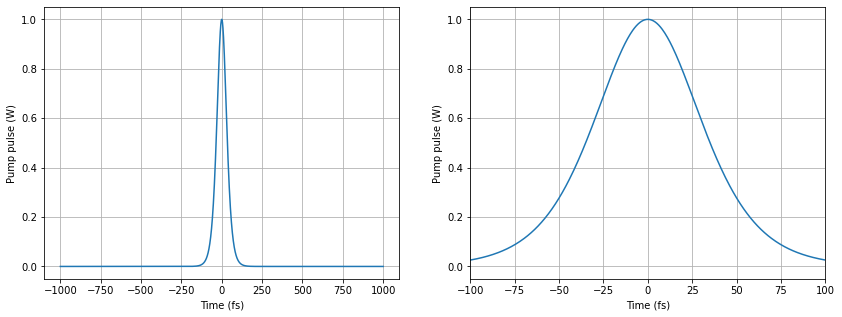

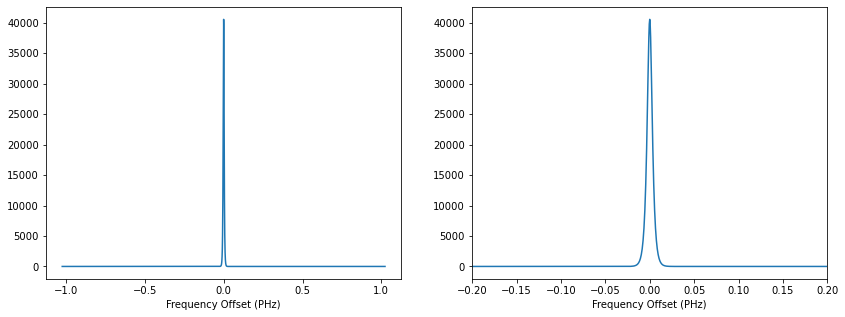

In [9]:
tau = Tp/1.76
b = np.sqrt(0.88*4e6/Tp*pump_pwr)/np.cosh(t/tau)
B = fft(b,NFFT)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,(b/np.amax(b))**2)
ax1.grid()
ax2.plot(t,(b/np.amax(b))**2)
ax2.grid()
ax2.set_xlim(-100,100)
ax1.set_xlabel('Time (fs)');
ax2.set_xlabel('Time (fs)');
ax1.set_ylabel('Pump pulse (W)');
ax2.set_ylabel('Pump pulse (W)');

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(fftshift(Omega)/(2*pi),fftshift(np.abs(B)))
ax2 = fig.add_subplot(122)
ax2.plot(fftshift(Omega)/(2*pi),fftshift(np.abs(B)))
ax2.set_xlim(-0.2,0.2)
ax1.set_xlabel('Frequency Offset (PHz)');
ax2.set_xlabel('Frequency Offset (PHz)');

## Single Pass Test

In [10]:
# a = b/10

# a_out, b_out = single_pass(a,b,Da,Db,kappa,L,h)
# # a_out, b_out = single_pass(a,b,Da,Db,0.01,L,h)

# fig = plt.figure()
# ax1 = fig.add_subplot(121)
# ax1.plot(t,abs(a),t,abs(b));
# ax1 = fig.add_subplot(122)
# ax1.plot(t,abs(a_out),t,abs(b_out));

## OPO Test

In [11]:
Db[1000]

(0.6088694976882258+0.7931832980680239j)

In [12]:
a_out, b_out, evol = opo(b, 1, L, h, Da, Db, fb, kappa);

In [13]:
a_out[0]

(-5.273688296565954e-11+2.6357532929107527e-11j)

In [14]:
tic = time.time();
a_out, b_out, evol = opo(b, Nrt, L, h, Da, Db, fb, kappa);
elapsed = time.time() - tic;
print('Time elapsed = ' + str(round(elapsed,5)) + ' seconds')

Completed roundtrip 50
Completed roundtrip 100
Completed roundtrip 150
Completed roundtrip 200
Completed roundtrip 250
Completed roundtrip 300
Time elapsed = 24.69511 seconds


(-30.0, 0.0)

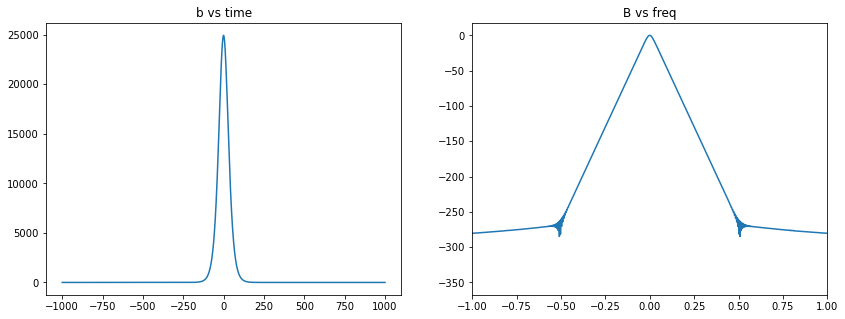

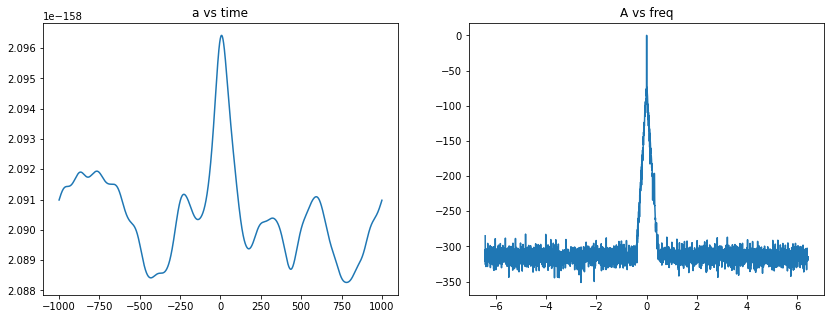

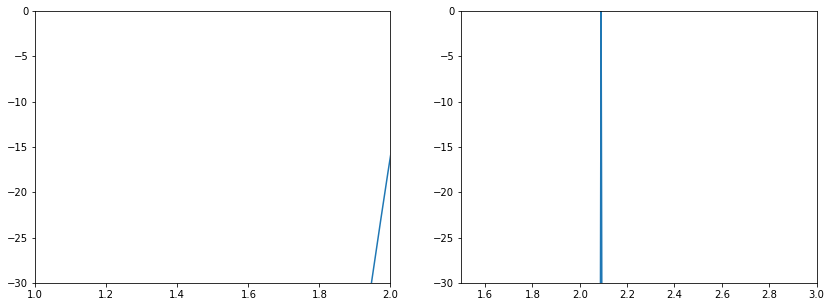

In [15]:
B = fftshift(fft(b_out))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,np.abs(b_out)**2);
ax2.plot(fftshift(Omega), 20*np.log10(abs(B)/np.amax(abs(B))))
ax2.set_xlim(-1,1);
ax1.set_title('b vs time');
ax2.set_title('B vs freq');

A = fftshift(fft(a_out))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,np.abs(a_out)**2);
ax2.plot(fftshift(Omega), 20*np.log10(abs(A)/np.amax(abs(A))))
#ax2.set_xlim(-1,1);
ax1.set_title('a vs time');
ax2.set_title('A vs freq');

f = c/wla + fftshift(Omega)/2/pi
wl = c/f
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(wl*1e3, 20*np.log10(abs(B)/np.amax(abs(B))))
ax1.set_xlim([1,2])
ax1.set_ylim([-30,0])

ax2.plot(wl*1e3, 20*np.log10(abs(A)/np.amax(abs(A))))
ax2.set_xlim([1.5,3])
ax2.set_ylim([-30,0])

In [16]:
np.amin(Omega) + wa

-5.531142265732101

(0.0, 100.0)

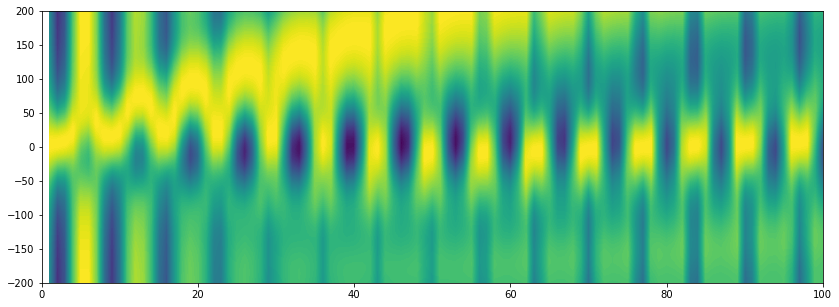

In [17]:
#plt.imshow(np.transpose(evol))
X,Y = np.meshgrid(np.arange(1,Nrt+1), t)
# Y.shape
plt.contourf(X, Y, np.transpose(evol), 100)
plt.ylim([-200,200])
plt.xlim([0,100])

(-200.0, 200.0)

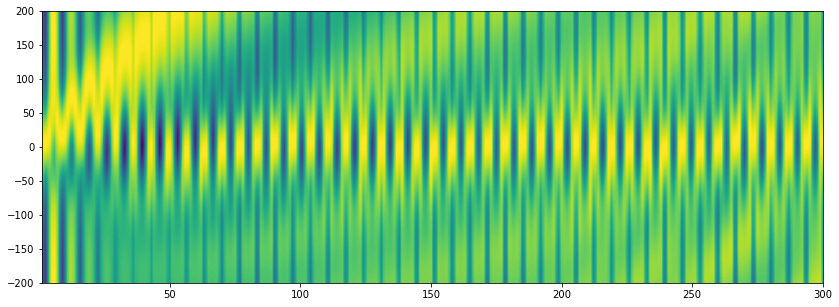

In [18]:
plt.contourf(X, Y, np.transpose(evol), 100)
plt.ylim([-200,200])

## Sweep Detuning